In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Field Definitions
- step: is a timestep, each timestep is 0.25 seconds
- spool: is the integral of material feedrate from the beginning of the production. This is proportional to the mass of the total fiber extruded.
- diameter: is in 10e-5 meter
- speed: is mapped between 0 and 100
- motorV: is the PWM dutycycle of the motor and it's mapped between 0 and 100
- extfrq: is the frequency of the feeding extruder, which corresponds to the feedrate of the material
- temp: is the temperture of the heating chamber
- rests of the columns can be ignored for now


In [15]:
columns = ['step', 'spool', 'diameter', 'speed', 'motorV', 'extfrq', 'target', 'greedy_m', 'greedy_e', 
           'reward', 'Q_exam', 'am_exam', 'a_exam', 'unk', 'temp']
df = pd.read_csv('2019_09_09_09_54.txt', header=0, names=columns)
df.reset_index(inplace=True, drop=True)
df = df.drop(['unk', 'Q_exam', 'am_exam', 'a_exam'], axis=1)
for col in df.columns:
    df[col] = df[col].str.split(':').apply(lambda x: x[1])
df = df.apply(pd.to_numeric)

In [16]:
df.head()

,step,spool,diameter,speed,motorV,extfrq,target,greedy_m,greedy_e,reward,temp
0,8741,0.00,34.9,75.04,9.81,0.00,30.6,0.52,0.20,0.570,80.105
1,8742,0.01,32.5,74.88,8.94,0.00,30.6,0.86,0.27,0.810,80.105
2,8743,0.02,32.6,75.28,10.08,1.95,30.6,1.44,0.42,0.800,80.071
3,8744,0.02,31.9,75.28,5.55,2.62,30.6,2.15,0.61,0.871,79.933
4,8745,0.03,33.7,75.12,8.60,0.28,30.6,2.87,0.75,0.691,80.002


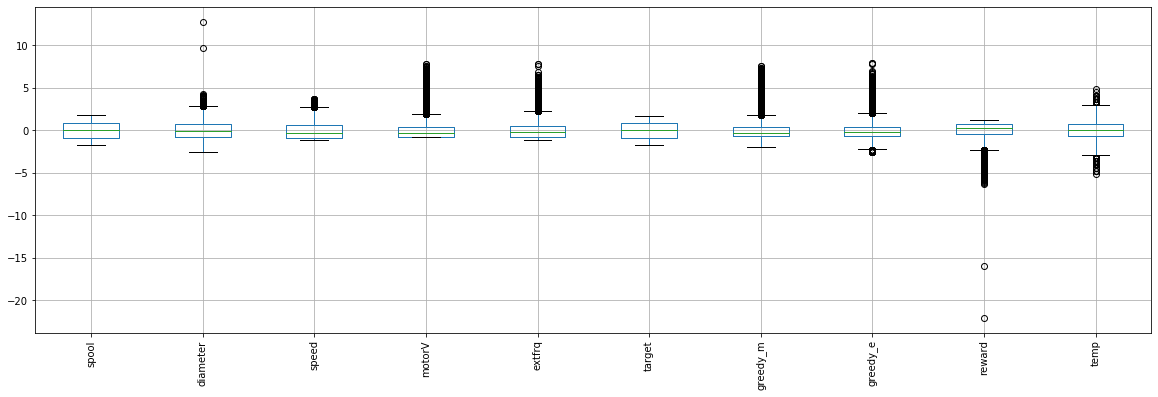

In [17]:
df_z = df.drop(['step'], axis = 1)
cols = df_z.columns
for col in cols:
    df_z[col] = (df_z[col] - df_z[col].mean())/df_z[col].std(ddof=0)

df_z.boxplot(figsize=(20,6), rot=90)

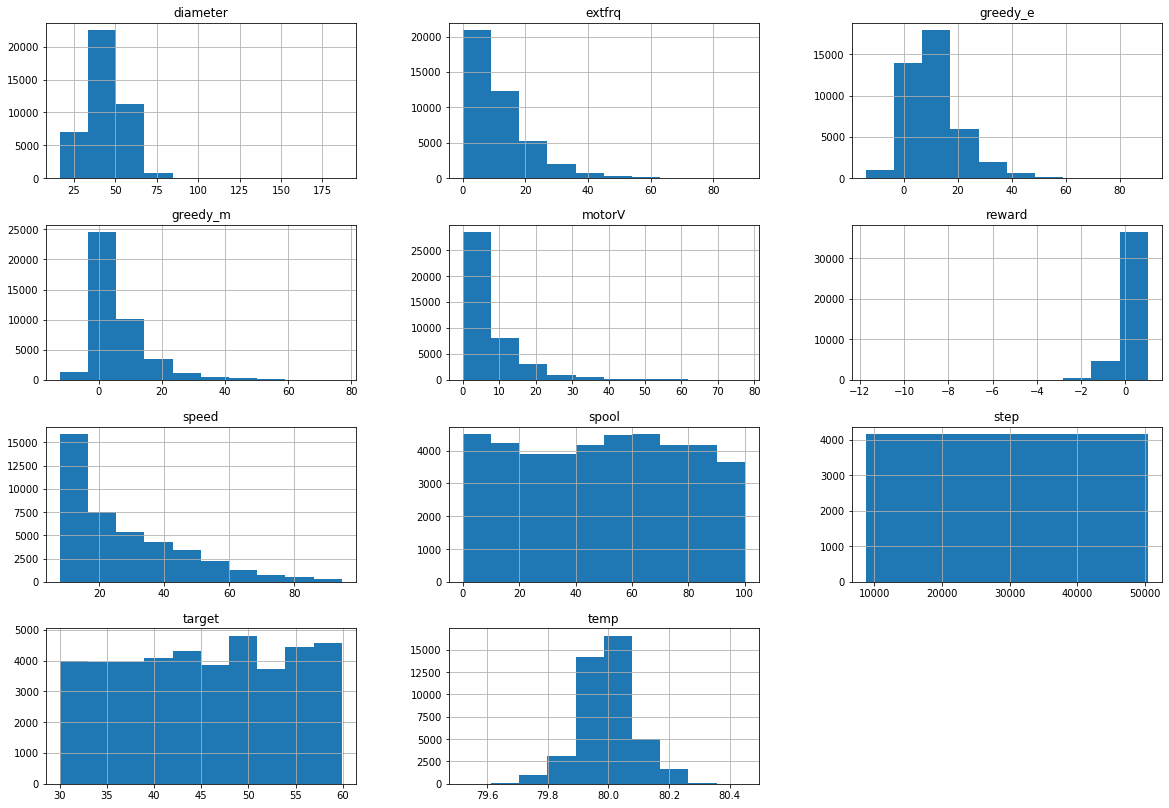

In [18]:
hist = df.hist(figsize=(20,14))

[Text(0.5, 0, 'step'),
 Text(1.5, 0, 'spool'),
 Text(2.5, 0, 'diameter'),
 Text(3.5, 0, 'speed'),
 Text(4.5, 0, 'motorV'),
 Text(5.5, 0, 'extfrq'),
 Text(6.5, 0, 'target'),
 Text(7.5, 0, 'greedy_m'),
 Text(8.5, 0, 'greedy_e'),
 Text(9.5, 0, 'reward'),
 Text(10.5, 0, 'temp')]

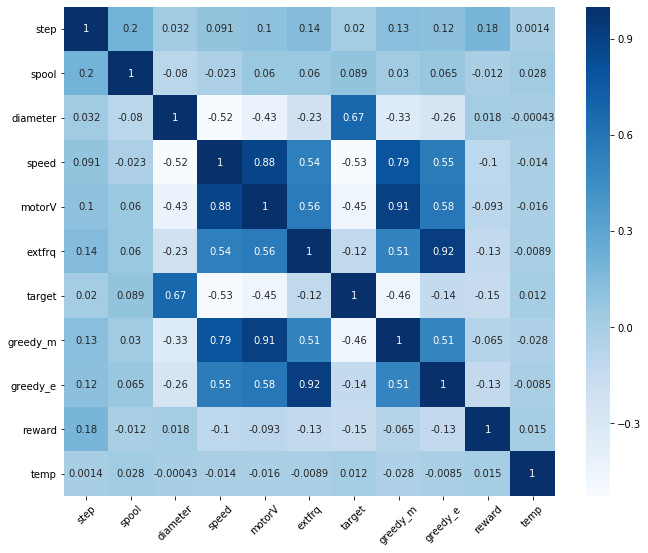

In [19]:
# Correlation Plot
f, ax = plt.subplots(figsize=(11, 9))
cor = df.corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)